# How to train your DragoNN tutorial 2: 
## CNN Hyperparameter Tuning via Grid Search 
This tutorial is a supplement to the DragoNN manuscript and follows figure 6 in the manuscript. 

This tutorial will take 2 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Define default CNN architecture helper utilities</a></li> 
    <li><a href=#3>Data simulation and default CNN model performance</a></li>
    <ol>
        <li><a href=#3a>Simple Motif Detection: TAL1, CTCF, ZNF143, SIX5 </a></li>
        <li><a href=#3b>Motif Density Detection</a></li>
        <li><a href=#3c>Motif Density Localization</a></li>
        <li><a href=#3d>Multiple Motif Detection</a></li>
        <li><a href=#3e>Heterodimer Motif Grammar: SPI1_IRF</a></li>
    </ol>
    <li><a href=#4>Hyperparameter grid search</a></li>
    <ol>
    <li><a href=#4a>Training examples</a></li>
    <li><a href=#4b>Convolutional Filter Width </a></li>  
    <li><a href=#4c>Number of convolution filters</a></li>
    <li><a href=#4d>Max Pooling Width</a></li>
    </ol>
    <li><a href=#5>Conclusions</a></li>
</ol>

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)


In [2]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [3]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [4]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *


Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Define basic CNN architecture helper utilities <a name='2'>
<a href=#outline>Home</a>


We start with a simple reference CNN architecture that contains a convolutional layer with 10 convolutional filters (size 15, stride 1) and ReLU activations, followed by max-pooling (size 35,stride 35), followed by a fully connected layer with a logistic output neuron for binary classification. Models are trained using the Adam optimizer with early stopping after 7 consecutive epochs without validation loss improvement. Performance (auROC) is recorded on an the independent test set.

We will initialize multiple models with this basic architecture, so we write helper functions to generate the architecture, perform training, print the loss curve, and print test set auROC. 

In [5]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


In [6]:
def build_default_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model 


In [7]:
from dragonn.callbacks import * 
def train_default_model(data,num_tasks,model_constructor=build_default_model):
    
    #Build the model 
    model=model_constructor(data.X_train.shape[1::],num_tasks)
    
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),
                                 validation_data=(data.X_valid,data.y_valid))
    #Train the Model
    history=model.fit(x=data.X_train,y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=7),
                                 History(),
                                 metrics_callback],
                      validation_data=(data.X_valid,data.y_valid))
    #Plot the learning curve
    plot_learning_curve(history)
    
    #Print model performance on held-out test set
    print("Test Set Performance:")
    test_predictions=model.predict(data.X_test)
    print(ClassificationResult(data.y_test,test_predictions))

    #return the trained model and history 
    return model,history


## Data simulation and basic architecture performance <a name='3'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [8]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


We design four single-task binary classification tasks using DNA sequences that simulate different
properties of regulatory DNA sequences: single motif, homotypic motif clusters, heterotypic motif
clusters, and heterodimer motif grammars with spatial constraints. We further design a multitask
classification simulation to jointly detect motif instances of 3 distinct TFs (corresponding to 3 binary
classification tasks, one per TF). In each simulation, we embed motif instances with the relevant
constraints in random sequences (G/C frequency = 0.4). We hold out 20% of sequences for a test
set, 16% for a validation set, and use the remaining sequences for training. Motif instances are
reverse complemented with 0.5 probability before they are embedded in the background sequence.

We train models with the default architecture for these 4 individual TF simulations and evaluate the models' performance: 

### Simple Motif Detection: <a name='3a'>
<a href=#outline>Home</a>

TAL1_Known4: 
![play button](./primer_tutorial_images/TAL1_known4.png)

Training Data:
Loss: 0.6930	Balanced Accuracy: 51.91%	 auROC: 0.526	 auPRC: 0.517
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6977	Balanced Accuracy: 49.88%	 auROC: 0.501	 auPRC: 0.499
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6897	Balanced Accuracy: 53.08%	 auROC: 0.546	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6964	Balanced Accuracy: 50.81%	 auROC: 0.507	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6871	Balanced Accuracy: 54.23%	 auROC: 0.563	 auPRC: 0.549
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6956	Balanced Accuracy: 51.03%	 auROC: 0.511	 auPRC: 0.509
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 160

Training Data:
Loss: 0.4517	Balanced Accuracy: 83.30%	 auROC: 0.898	 auPRC: 0.879
	Recall at 5%|10%|20% FDR: 0.1%|53.1%|87.7%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4583	Balanced Accuracy: 82.28%	 auROC: 0.893	 auPRC: 0.883
	Recall at 5%|10%|20% FDR: 15.8%|54.6%|85.6%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4437	Balanced Accuracy: 82.49%	 auROC: 0.903	 auPRC: 0.885
	Recall at 5%|10%|20% FDR: 0.1%|58.2%|89.2%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4509	Balanced Accuracy: 81.44%	 auROC: 0.898	 auPRC: 0.888
	Recall at 5%|10%|20% FDR: 20.5%|58.1%|87.6%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4311	Balanced Accuracy: 84.37%	 auROC: 0.906	 auPRC: 0.889
	Recall at 5%|10%|20% FDR: 0.2%|61.6%|89.8%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4372	Balanced Accuracy: 83.72%	 auROC: 0.902	 auPRC: 0.892
	Recall at 5%|10%|20% FDR: 22.8%|59.3%|89.7%	 Num Positives: 1600	 Num

Training Data:
Loss: 0.3147	Balanced Accuracy: 89.34%	 auROC: 0.941	 auPRC: 0.931
	Recall at 5%|10%|20% FDR: 61.2%|88.4%|94.9%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3235	Balanced Accuracy: 88.91%	 auROC: 0.936	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 55.4%|87.4%|94.1%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3122	Balanced Accuracy: 89.59%	 auROC: 0.942	 auPRC: 0.933
	Recall at 5%|10%|20% FDR: 61.7%|88.7%|95.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3211	Balanced Accuracy: 89.25%	 auROC: 0.937	 auPRC: 0.934
	Recall at 5%|10%|20% FDR: 56.4%|87.9%|94.2%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3124	Balanced Accuracy: 89.51%	 auROC: 0.942	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 61.1%|88.6%|94.9%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3210	Balanced Accuracy: 89.16%	 auROC: 0.937	 auPRC: 0.933
	Recall at 5%|10%|20% FDR: 57.7%|88.0%|94.3%	 Num Positives: 1600	 

Training Data:
Loss: 0.2886	Balanced Accuracy: 90.12%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 69.6%|90.5%|95.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3053	Balanced Accuracy: 89.47%	 auROC: 0.940	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 65.4%|89.4%|94.2%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2875	Balanced Accuracy: 90.32%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 70.1%|90.6%|95.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3043	Balanced Accuracy: 89.75%	 auROC: 0.940	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 66.6%|89.5%|94.1%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2872	Balanced Accuracy: 90.39%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 70.4%|90.7%|95.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3041	Balanced Accuracy: 89.81%	 auROC: 0.939	 auPRC: 0.937
	Recall at 5%|10%|20% FDR: 66.1%|89.5%|94.1%	 Num Positives: 1600	 

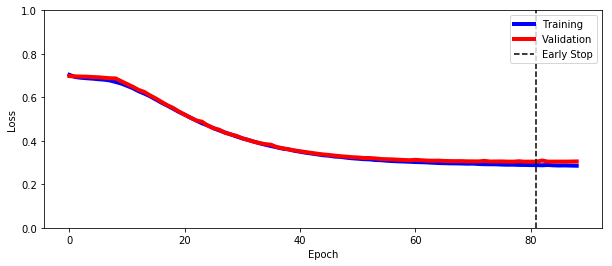

Test Set Performance:
Loss: 0.3362	Balanced Accuracy: 88.49%	 auROC: 0.929	 auPRC: 0.923
	Recall at 5%|10%|20% FDR: 34.5%|86.6%|94.0%	 Num Positives: 2045	 Num Negatives: 1955


In [9]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
tal1_default_model,tal1_default_history=train_default_model(tal1_data,1)

CTCF_Known1: 
![play button](./primer_tutorial_images/CTCF_known1.png)

Training Data:
Loss: 0.6961	Balanced Accuracy: 50.58%	 auROC: 0.521	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.7008	Balanced Accuracy: 50.30%	 auROC: 0.493	 auPRC: 0.499
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: 0.6914	Balanced Accuracy: 52.56%	 auROC: 0.549	 auPRC: 0.538
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.6984	Balanced Accuracy: 49.82%	 auROC: 0.507	 auPRC: 0.509
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: 0.6849	Balanced Accuracy: 54.84%	 auROC: 0.574	 auPRC: 0.562
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.6945	Balanced Accuracy: 51.20%	 auROC: 0.520	 auPRC: 0.519
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1591	 Num Negatives: 160

Training Data:
Loss: 0.3246	Balanced Accuracy: 88.30%	 auROC: 0.943	 auPRC: 0.950
	Recall at 5%|10%|20% FDR: 77.0%|86.2%|92.8%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.3396	Balanced Accuracy: 86.96%	 auROC: 0.935	 auPRC: 0.942
	Recall at 5%|10%|20% FDR: 72.1%|83.0%|91.6%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: 0.3170	Balanced Accuracy: 88.44%	 auROC: 0.944	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 77.4%|86.3%|93.0%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.3319	Balanced Accuracy: 87.14%	 auROC: 0.937	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 72.7%|83.5%|91.8%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: 0.3106	Balanced Accuracy: 88.63%	 auROC: 0.946	 auPRC: 0.953
	Recall at 5%|10%|20% FDR: 78.4%|86.8%|93.1%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.3253	Balanced Accuracy: 87.57%	 auROC: 0.939	 auPRC: 0.946
	Recall at 5%|10%|20% FDR: 74.1%|84.0%|91.9%	 Num Positives: 1591	 

Training Data:
Loss: nan	Balanced Accuracy: 90.14%	 auROC: 0.957	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 84.6%|89.8%|94.2%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.2878	Balanced Accuracy: 88.56%	 auROC: 0.944	 auPRC: 0.956
	Recall at 5%|10%|20% FDR: 81.1%|85.9%|92.5%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: nan	Balanced Accuracy: 90.42%	 auROC: 0.957	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 84.4%|89.7%|94.2%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.2838	Balanced Accuracy: 88.48%	 auROC: 0.944	 auPRC: 0.956
	Recall at 5%|10%|20% FDR: 80.8%|86.0%|92.6%	 Num Positives: 1591	 Num Negatives: 1609
Training Data:
Loss: nan	Balanced Accuracy: 90.45%	 auROC: 0.957	 auPRC: 0.965
	Recall at 5%|10%|20% FDR: 84.8%|89.8%|94.3%	 Num Positives: 6406	 Num Negatives: 6394
Validation Data:
Loss: 0.2848	Balanced Accuracy: 88.63%	 auROC: 0.944	 auPRC: 0.956
	Recall at 5%|10%|20% FDR: 81.4%|85.9%|92.6%	 Num Positives: 1591	 Num Negat

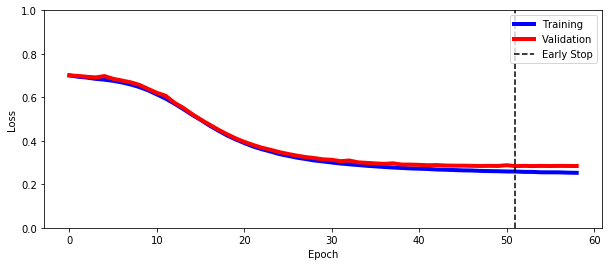

Test Set Performance:
Loss: 0.3116	Balanced Accuracy: 87.65%	 auROC: 0.933	 auPRC: 0.947
	Recall at 5%|10%|20% FDR: 77.2%|84.8%|90.8%	 Num Positives: 2003	 Num Negatives: 1997


In [10]:
#Define simulation parameters 
ctcf_parameters = {
    "motif_name": "CTCF_known1",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
ctcf_data = get_simulation_data("simulate_single_motif_detection",
                                      ctcf_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
ctcf_default_model,ctcf_default_history=train_default_model(ctcf_data,1)

ZNF143_known2: 
![play button](./primer_tutorial_images/ZNF143_known2.png)

Training Data:
Loss: 0.6943	Balanced Accuracy: 51.33%	 auROC: 0.528	 auPRC: 0.518
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.6970	Balanced Accuracy: 51.32%	 auROC: 0.518	 auPRC: 0.532
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.6888	Balanced Accuracy: 53.57%	 auROC: 0.557	 auPRC: 0.546
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.6944	Balanced Accuracy: 51.83%	 auROC: 0.532	 auPRC: 0.542
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.6824	Balanced Accuracy: 55.83%	 auROC: 0.589	 auPRC: 0.579
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.6900	Balanced Accuracy: 53.65%	 auROC: 0.553	 auPRC: 0.559
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1634	 Num Negatives: 156

Training Data:
Loss: 0.3122	Balanced Accuracy: 90.26%	 auROC: 0.951	 auPRC: 0.956
	Recall at 5%|10%|20% FDR: 81.2%|90.3%|94.8%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.3354	Balanced Accuracy: 88.69%	 auROC: 0.939	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 79.0%|86.4%|92.9%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.3015	Balanced Accuracy: 90.68%	 auROC: 0.953	 auPRC: 0.958
	Recall at 5%|10%|20% FDR: 83.2%|90.6%|94.9%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.3250	Balanced Accuracy: 88.78%	 auROC: 0.941	 auPRC: 0.953
	Recall at 5%|10%|20% FDR: 79.9%|86.9%|93.2%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.2931	Balanced Accuracy: 90.85%	 auROC: 0.955	 auPRC: 0.960
	Recall at 5%|10%|20% FDR: 84.3%|91.3%|95.1%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.3153	Balanced Accuracy: 88.85%	 auROC: 0.943	 auPRC: 0.955
	Recall at 5%|10%|20% FDR: 81.2%|88.6%|93.6%	 Num Positives: 1634	 

Training Data:
Loss: 0.1623	Balanced Accuracy: 95.31%	 auROC: 0.978	 auPRC: 0.983
	Recall at 5%|10%|20% FDR: 94.0%|94.8%|96.6%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1903	Balanced Accuracy: 94.55%	 auROC: 0.963	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 92.8%|93.5%|94.8%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.1588	Balanced Accuracy: 95.53%	 auROC: 0.979	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 94.1%|94.9%|96.6%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1885	Balanced Accuracy: 94.71%	 auROC: 0.964	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 92.8%|93.6%|94.7%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.1570	Balanced Accuracy: 95.48%	 auROC: 0.979	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 94.1%|95.0%|96.8%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1860	Balanced Accuracy: 94.65%	 auROC: 0.964	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 92.9%|93.6%|94.7%	 Num Positives: 1634	 

Training Data:
Loss: 0.1274	Balanced Accuracy: 96.16%	 auROC: 0.985	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.8%|96.1%|97.8%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1716	Balanced Accuracy: 95.26%	 auROC: 0.967	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 93.1%|93.9%|95.5%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.1263	Balanced Accuracy: 96.10%	 auROC: 0.985	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.8%|96.1%|97.8%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1698	Balanced Accuracy: 95.22%	 auROC: 0.967	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 93.1%|93.9%|95.5%	 Num Positives: 1634	 Num Negatives: 1566
Training Data:
Loss: 0.1261	Balanced Accuracy: 96.07%	 auROC: 0.985	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.8%|96.1%|97.8%	 Num Positives: 6371	 Num Negatives: 6429
Validation Data:
Loss: 0.1693	Balanced Accuracy: 95.12%	 auROC: 0.967	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 93.1%|93.9%|95.5%	 Num Positives: 1634	 

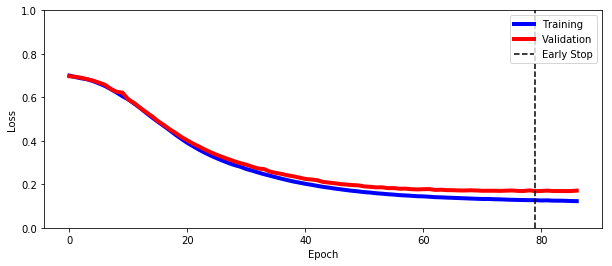

Test Set Performance:
Loss: 0.1768	Balanced Accuracy: 95.17%	 auROC: 0.963	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 92.9%|93.3%|94.5%	 Num Positives: 1995	 Num Negatives: 2005


In [11]:
#Define simulation parameters 
znf143_parameters={
    "motif_name": "ZNF143_known2",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data 
znf143_data=get_simulation_data("simulate_single_motif_detection",
                               znf143_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
znf143_default_model,znf143_default_history=train_default_model(znf143_data,1)

SIX5_known1:  
![play button](./primer_tutorial_images/SIX5_known1.png) 

Training Data:
Loss: 0.6950	Balanced Accuracy: 51.25%	 auROC: 0.520	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.6984	Balanced Accuracy: 50.12%	 auROC: 0.500	 auPRC: 0.501
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.6914	Balanced Accuracy: 52.74%	 auROC: 0.537	 auPRC: 0.528
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.6975	Balanced Accuracy: 49.11%	 auROC: 0.499	 auPRC: 0.503
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.6939	Balanced Accuracy: 52.03%	 auROC: 0.553	 auPRC: 0.542
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.7022	Balanced Accuracy: 50.68%	 auROC: 0.497	 auPRC: 0.501
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1596	 Num Negatives: 160

Training Data:
Loss: 0.5561	Balanced Accuracy: 73.84%	 auROC: 0.815	 auPRC: 0.803
	Recall at 5%|10%|20% FDR: 6.0%|20.4%|57.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.5890	Balanced Accuracy: 69.89%	 auROC: 0.768	 auPRC: 0.748
	Recall at 5%|10%|20% FDR: 1.8%|5.3%|35.1%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.5509	Balanced Accuracy: 74.68%	 auROC: 0.819	 auPRC: 0.806
	Recall at 5%|10%|20% FDR: 5.9%|21.4%|58.5%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.5856	Balanced Accuracy: 70.83%	 auROC: 0.773	 auPRC: 0.753
	Recall at 5%|10%|20% FDR: 2.2%|5.3%|36.0%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.5430	Balanced Accuracy: 75.48%	 auROC: 0.824	 auPRC: 0.812
	Recall at 5%|10%|20% FDR: 5.8%|23.1%|62.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.5776	Balanced Accuracy: 71.53%	 auROC: 0.780	 auPRC: 0.760
	Recall at 5%|10%|20% FDR: 2.5%|6.3%|38.2%	 Num Positives: 1596	 Num Negat

Training Data:
Loss: 0.4587	Balanced Accuracy: 80.23%	 auROC: 0.871	 auPRC: 0.865
	Recall at 5%|10%|20% FDR: 5.6%|54.0%|80.0%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.5021	Balanced Accuracy: 78.59%	 auROC: 0.837	 auPRC: 0.829
	Recall at 5%|10%|20% FDR: 8.1%|15.0%|76.4%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.4574	Balanced Accuracy: 80.19%	 auROC: 0.872	 auPRC: 0.867
	Recall at 5%|10%|20% FDR: 5.6%|56.2%|80.1%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.5005	Balanced Accuracy: 78.93%	 auROC: 0.838	 auPRC: 0.830
	Recall at 5%|10%|20% FDR: 8.7%|15.5%|76.9%	 Num Positives: 1596	 Num Negatives: 1604
Training Data:
Loss: 0.4563	Balanced Accuracy: 80.30%	 auROC: 0.873	 auPRC: 0.867
	Recall at 5%|10%|20% FDR: 5.6%|57.0%|80.1%	 Num Positives: 6372	 Num Negatives: 6428
Validation Data:
Loss: 0.4997	Balanced Accuracy: 79.15%	 auROC: 0.838	 auPRC: 0.831
	Recall at 5%|10%|20% FDR: 8.8%|15.0%|77.1%	 Num Positives: 1596	 Num Ne

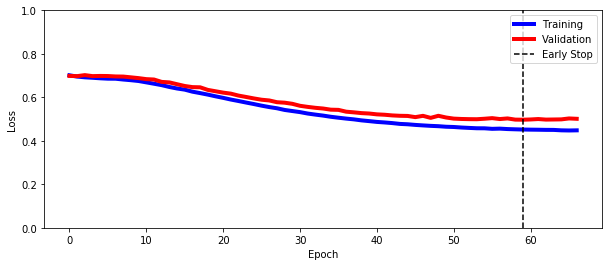

Test Set Performance:
Loss: 0.5024	Balanced Accuracy: 77.22%	 auROC: 0.834	 auPRC: 0.840
	Recall at 5%|10%|20% FDR: 4.2%|40.0%|73.8%	 Num Positives: 2032	 Num Negatives: 1968


In [12]:
#Define simulation parameters 
six5_parameters={
    "motif_name": "SIX5_known1",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
six5_data=get_simulation_data("simulate_single_motif_detection",
                               six5_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
six5_default_model,six5_default_history=train_default_model(six5_data,1)

### Motif Density Detection <a name='3b'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 10K 500 bp random sequences with 0-2 instances of a TAL1 motif embedded at any random position and
10K 500 bp random sequences with 3-5 instances of the motif embedded at any random position. To solve this simulation, the model needs to learn the differences in motif counts.

In [13]:
print_simulation_info("simulate_motif_counting")



    Generates data for motif counting task.

    Parameters
    ----------
    motif_name : str
    seq_length : int
    pos_counts : list
        (min_counts, max_counts) for positive set.
    neg_counts : list
        (min_counts, max_counts) for negative set.
    num_pos : int
    num_neg : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darray
        Contains labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Loss: 0.6949	Balanced Accuracy: 51.51%	 auROC: 0.522	 auPRC: 0.515
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.6991	Balanced Accuracy: 49.29%	 auROC: 0.494	 auPRC: 0.487
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.6908	Balanced Accuracy: 53.27%	 auROC: 0.544	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.6976	Balanced Accuracy: 50.57%	 auROC: 0.506	 auPRC: 0.496
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.6856	Balanced Accuracy: 55.23%	 auROC: 0.575	 auPRC: 0.560
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.2%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.6937	Balanced Accuracy: 51.64%	 auROC: 0.529	 auPRC: 0.518
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1574	 Num Negatives: 162

Training Data:
Loss: 0.2170	Balanced Accuracy: 91.25%	 auROC: 0.974	 auPRC: 0.975
	Recall at 5%|10%|20% FDR: 85.4%|92.1%|97.9%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2383	Balanced Accuracy: 90.54%	 auROC: 0.967	 auPRC: 0.967
	Recall at 5%|10%|20% FDR: 81.4%|91.0%|95.7%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.2138	Balanced Accuracy: 91.42%	 auROC: 0.974	 auPRC: 0.975
	Recall at 5%|10%|20% FDR: 85.9%|92.5%|98.0%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2356	Balanced Accuracy: 90.57%	 auROC: 0.968	 auPRC: 0.968
	Recall at 5%|10%|20% FDR: 81.4%|91.2%|95.7%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.2129	Balanced Accuracy: 91.39%	 auROC: 0.975	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 86.3%|92.6%|98.0%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2328	Balanced Accuracy: 90.61%	 auROC: 0.968	 auPRC: 0.969
	Recall at 5%|10%|20% FDR: 82.2%|91.0%|95.9%	 Num Positives: 1574	 

Training Data:
Loss: 0.1753	Balanced Accuracy: 93.34%	 auROC: 0.983	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 91.5%|95.1%|98.7%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2074	Balanced Accuracy: 92.12%	 auROC: 0.974	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 87.4%|92.5%|96.2%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1694	Balanced Accuracy: 93.36%	 auROC: 0.983	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 91.6%|95.1%|98.7%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2042	Balanced Accuracy: 92.05%	 auROC: 0.974	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 87.3%|92.4%|96.2%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1680	Balanced Accuracy: 93.40%	 auROC: 0.984	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 91.8%|95.3%|98.7%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2036	Balanced Accuracy: 92.12%	 auROC: 0.974	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 87.4%|92.4%|96.3%	 Num Positives: 1574	 

Training Data:
Loss: 0.1515	Balanced Accuracy: 93.82%	 auROC: 0.986	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 93.0%|96.2%|99.2%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2007	Balanced Accuracy: 91.82%	 auROC: 0.976	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 89.9%|92.6%|97.0%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1507	Balanced Accuracy: 93.94%	 auROC: 0.986	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 93.1%|96.2%|99.2%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.2004	Balanced Accuracy: 91.85%	 auROC: 0.976	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 89.9%|92.8%|97.0%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1494	Balanced Accuracy: 94.08%	 auROC: 0.987	 auPRC: 0.987
	Recall at 5%|10%|20% FDR: 93.2%|96.2%|99.2%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.1986	Balanced Accuracy: 92.03%	 auROC: 0.976	 auPRC: 0.978
	Recall at 5%|10%|20% FDR: 89.7%|92.7%|97.0%	 Num Positives: 1574	 

Training Data:
Loss: 0.1370	Balanced Accuracy: 94.59%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.2%|97.0%|99.3%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.1927	Balanced Accuracy: 92.24%	 auROC: 0.977	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 90.3%|92.5%|96.5%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1366	Balanced Accuracy: 94.69%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.2%|97.0%|99.3%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.1932	Balanced Accuracy: 92.09%	 auROC: 0.977	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 90.5%|92.4%|96.5%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: 0.1394	Balanced Accuracy: 94.52%	 auROC: 0.989	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 94.3%|97.1%|99.4%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: 0.1949	Balanced Accuracy: 92.81%	 auROC: 0.977	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 90.4%|92.4%|96.5%	 Num Positives: 1574	 

Training Data:
Loss: nan	Balanced Accuracy: 95.13%	 auROC: 0.990	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.2%|97.4%|99.4%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: nan	Balanced Accuracy: 91.75%	 auROC: 0.978	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 90.5%|92.5%|96.3%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: nan	Balanced Accuracy: 95.24%	 auROC: 0.990	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.2%|97.4%|99.4%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: nan	Balanced Accuracy: 92.42%	 auROC: 0.978	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 90.3%|92.6%|96.4%	 Num Positives: 1574	 Num Negatives: 1626
Training Data:
Loss: nan	Balanced Accuracy: 95.14%	 auROC: 0.990	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.2%|97.4%|99.4%	 Num Positives: 6390	 Num Negatives: 6410
Validation Data:
Loss: nan	Balanced Accuracy: 91.79%	 auROC: 0.978	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 90.4%|92.5%|96.4%	 Num Positives: 1574	 Num Negatives: 162

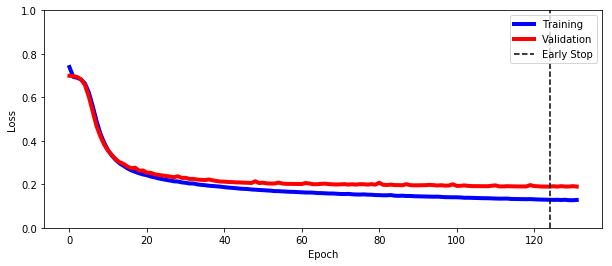

Test Set Performance:
Loss: nan	Balanced Accuracy: 93.09%	 auROC: 0.983	 auPRC: 0.985
	Recall at 5%|10%|20% FDR: 91.8%|94.9%|98.3%	 Num Positives: 2036	 Num Negatives: 1964


In [14]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_detection_default_model,density_detection_default_history=train_default_model(density_detection_data,1)

### Motif Density Localization <a name='3c'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 20K random sequences of length 1 Kbp with 2-4 embedded instances of the TAL1 motif. In the positive set of 10K sequences, the motif instances are embedded in the central 150bp. The negative set of 10K sequences, contain embedded motif instances at any random position. To solve this simulation, the model needs to learn localization differences of the motif instances.

In [15]:
print_simulation_info("simulate_motif_density_localization")



    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Training Data:
Loss: 0.6770	Balanced Accuracy: 57.07%	 auROC: 0.627	 auPRC: 0.605
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.4%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.6789	Balanced Accuracy: 56.30%	 auROC: 0.620	 auPRC: 0.611
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|1.0%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: 0.5886	Balanced Accuracy: 79.78%	 auROC: 0.880	 auPRC: 0.869
	Recall at 5%|10%|20% FDR: 21.6%|47.5%|78.7%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.5915	Balanced Accuracy: 78.28%	 auROC: 0.870	 auPRC: 0.861
	Recall at 5%|10%|20% FDR: 12.7%|48.1%|75.2%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: 0.4197	Balanced Accuracy: 89.51%	 auROC: 0.962	 auPRC: 0.960
	Recall at 5%|10%|20% FDR: 73.6%|88.4%|97.4%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.4266	Balanced Accuracy: 88.81%	 auROC: 0.954	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 65.2%|85.8%|96.3%	 Num Positives: 1608	 Num Ne

Training Data:
Loss: 0.1239	Balanced Accuracy: 95.32%	 auROC: 0.991	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 95.5%|99.0%|99.9%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1593	Balanced Accuracy: 93.78%	 auROC: 0.984	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 91.7%|96.7%|99.5%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: 0.1222	Balanced Accuracy: 95.38%	 auROC: 0.991	 auPRC: 0.990
	Recall at 5%|10%|20% FDR: 95.8%|99.1%|99.9%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1581	Balanced Accuracy: 93.72%	 auROC: 0.984	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 92.0%|96.8%|99.6%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: 0.1192	Balanced Accuracy: 95.51%	 auROC: 0.991	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 96.1%|99.1%|99.9%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: 0.1562	Balanced Accuracy: 93.90%	 auROC: 0.985	 auPRC: 0.984
	Recall at 5%|10%|20% FDR: 92.0%|97.0%|99.6%	 Num Positives: 1608	 

Training Data:
Loss: nan	Balanced Accuracy: 97.35%	 auROC: 0.996	 auPRC: 0.996
	Recall at 5%|10%|20% FDR: 99.1%|99.8%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 94.87%	 auROC: 0.990	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.7%|98.7%|99.9%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: nan	Balanced Accuracy: 97.38%	 auROC: 0.996	 auPRC: 0.996
	Recall at 5%|10%|20% FDR: 99.1%|99.8%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 94.90%	 auROC: 0.990	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.6%|98.9%|99.9%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: nan	Balanced Accuracy: 97.38%	 auROC: 0.996	 auPRC: 0.996
	Recall at 5%|10%|20% FDR: 99.1%|99.9%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 94.77%	 auROC: 0.990	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 94.5%|98.8%|99.9%	 Num Positives: 1608	 Num Negatives: 

Training Data:
Loss: nan	Balanced Accuracy: 98.09%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.6%|100.0%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 95.28%	 auROC: 0.991	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.2%|99.2%|99.8%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: nan	Balanced Accuracy: 98.12%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.7%|100.0%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 95.12%	 auROC: 0.991	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.3%|99.3%|99.9%	 Num Positives: 1608	 Num Negatives: 1592
Training Data:
Loss: nan	Balanced Accuracy: 98.13%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.7%|100.0%|100.0%	 Num Positives: 6358	 Num Negatives: 6442
Validation Data:
Loss: nan	Balanced Accuracy: 95.28%	 auROC: 0.991	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 95.3%|99.3%|99.9%	 Num Positives: 1608	 Num Negative

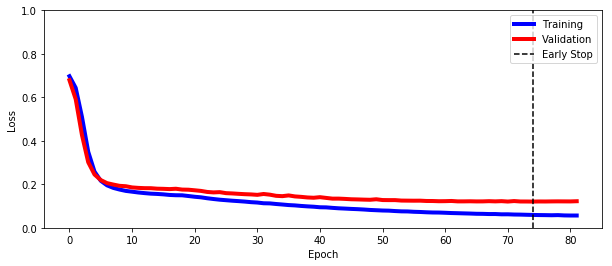

Test Set Performance:
Loss: nan	Balanced Accuracy: 95.98%	 auROC: 0.993	 auPRC: 0.993
	Recall at 5%|10%|20% FDR: 97.3%|99.4%|100.0%	 Num Positives: 2034	 Num Negatives: 1966


In [16]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_localization_default_model,density_localization_default_history=train_default_model(density_localization_data,1)

### Multiple Motif Detection <a name='3d'>
<a href=#outline>Home</a>

In this simulation of multiple co-binding TFs, we simulate 20K 500 bp random sequences. For each sequence, we independently embed 0 or 1 instance of motifs corresponding to 3 TFs: CTCF, ZNF143, and SIX5 (See SM). Each sequence has binary labels for 3 tasks corresponding to the presence/absence of a motif instance of each of the three TFs. We train a multitask CNN such as that the last layer of the model now has three output logistic neurons corresponding to the three separate tasks. To solve this simulation, the model needs to detect all three motifs while sharing parameters.

In [17]:
print_simulation_info("simulate_multi_motif_embedding")



    Generates data for multi motif recognition task.

    Parameters
    ----------
    motif_names : list
        List of strings.
    seq_length : int
    min_num_motifs : int
    max_num_motifs : int
    num_seqs : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : ndarray
        Contains labels for each motif.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Task 0: Loss: 0.4512	Balanced Accuracy: 50.00%	 auROC: 0.506	 auPRC: 0.167
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.4424	Balanced Accuracy: 50.00%	 auROC: 0.504	 auPRC: 0.166
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4495	Balanced Accuracy: 50.00%	 auROC: 0.505	 auPRC: 0.168
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.4633	Balanced Accuracy: 50.00%	 auROC: 0.509	 auPRC: 0.176
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.4467	Balanced Accuracy: 50.00%	 auROC: 0.466	 auPRC: 0.147
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4492	Balanced Accuracy: 50.00%	 auROC: 0.512	 auPRC: 0.181
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 525	 Num Negatives: 2675
Training Data:

Training Data:
Task 0: Loss: 0.4423	Balanced Accuracy: 50.00%	 auROC: 0.593	 auPRC: 0.219
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.4315	Balanced Accuracy: 50.00%	 auROC: 0.625	 auPRC: 0.246
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4411	Balanced Accuracy: 50.00%	 auROC: 0.587	 auPRC: 0.211
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.4625	Balanced Accuracy: 50.00%	 auROC: 0.529	 auPRC: 0.183
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.4391	Balanced Accuracy: 50.00%	 auROC: 0.550	 auPRC: 0.188
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4490	Balanced Accuracy: 50.00%	 auROC: 0.511	 auPRC: 0.175
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.8%	 Num Positives: 525	 Num Negatives: 2675
Training Data:

Training Data:
Task 0: Loss: 0.4301	Balanced Accuracy: 50.00%	 auROC: 0.660	 auPRC: 0.281
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.4061	Balanced Accuracy: 50.00%	 auROC: 0.746	 auPRC: 0.391
	Recall at 5%|10%|20% FDR: 0.1%|0.6%|0.9%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4366	Balanced Accuracy: 50.00%	 auROC: 0.611	 auPRC: 0.228
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.4541	Balanced Accuracy: 50.00%	 auROC: 0.596	 auPRC: 0.229
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.4165	Balanced Accuracy: 50.00%	 auROC: 0.690	 auPRC: 0.336
	Recall at 5%|10%|20% FDR: 0.8%|2.3%|2.9%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4503	Balanced Accuracy: 50.00%	 auROC: 0.519	 auPRC: 0.173
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Training Data:

Training Data:
Task 0: Loss: 0.3787	Balanced Accuracy: 51.19%	 auROC: 0.804	 auPRC: 0.479
	Recall at 5%|10%|20% FDR: 2.2%|3.2%|4.6%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.3546	Balanced Accuracy: 55.87%	 auROC: 0.825	 auPRC: 0.531
	Recall at 5%|10%|20% FDR: 2.0%|4.2%|9.3%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4316	Balanced Accuracy: 50.00%	 auROC: 0.634	 auPRC: 0.241
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.4054	Balanced Accuracy: 51.44%	 auROC: 0.762	 auPRC: 0.426
	Recall at 5%|10%|20% FDR: 1.8%|2.5%|2.9%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.3647	Balanced Accuracy: 55.37%	 auROC: 0.805	 auPRC: 0.490
	Recall at 5%|10%|20% FDR: 3.3%|3.3%|4.7%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4481	Balanced Accuracy: 50.00%	 auROC: 0.553	 auPRC: 0.190
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Training Data:

Training Data:
Task 0: Loss: 0.2890	Balanced Accuracy: 64.71%	 auROC: 0.911	 auPRC: 0.728
	Recall at 5%|10%|20% FDR: 9.3%|19.3%|46.4%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.2745	Balanced Accuracy: 68.73%	 auROC: 0.925	 auPRC: 0.764
	Recall at 5%|10%|20% FDR: 19.9%|29.5%|56.9%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4232	Balanced Accuracy: 50.00%	 auROC: 0.665	 auPRC: 0.271
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.3134	Balanced Accuracy: 63.06%	 auROC: 0.885	 auPRC: 0.676
	Recall at 5%|10%|20% FDR: 7.9%|15.5%|32.1%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.2924	Balanced Accuracy: 66.95%	 auROC: 0.898	 auPRC: 0.704
	Recall at 5%|10%|20% FDR: 5.3%|25.7%|43.6%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4415	Balanced Accuracy: 50.00%	 auROC: 0.590	 auPRC: 0.204
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Train

Training Data:
Task 0: Loss: 0.2252	Balanced Accuracy: 80.41%	 auROC: 0.942	 auPRC: 0.833
	Recall at 5%|10%|20% FDR: 29.2%|54.9%|71.7%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.2000	Balanced Accuracy: 80.43%	 auROC: 0.957	 auPRC: 0.872
	Recall at 5%|10%|20% FDR: 46.3%|69.3%|82.1%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4135	Balanced Accuracy: 50.00%	 auROC: 0.697	 auPRC: 0.292
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.7%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.2478	Balanced Accuracy: 78.38%	 auROC: 0.926	 auPRC: 0.801
	Recall at 5%|10%|20% FDR: 24.4%|45.8%|63.2%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.2233	Balanced Accuracy: 76.23%	 auROC: 0.935	 auPRC: 0.828
	Recall at 5%|10%|20% FDR: 38.1%|50.0%|73.5%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4347	Balanced Accuracy: 49.98%	 auROC: 0.624	 auPRC: 0.216
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1907	Balanced Accuracy: 83.30%	 auROC: 0.951	 auPRC: 0.867
	Recall at 5%|10%|20% FDR: 48.3%|64.5%|78.0%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1614	Balanced Accuracy: 84.03%	 auROC: 0.966	 auPRC: 0.911
	Recall at 5%|10%|20% FDR: 69.4%|80.7%|87.7%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.4046	Balanced Accuracy: 50.07%	 auROC: 0.716	 auPRC: 0.307
	Recall at 5%|10%|20% FDR: 0.1%|0.5%|0.6%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.2133	Balanced Accuracy: 82.09%	 auROC: 0.935	 auPRC: 0.841
	Recall at 5%|10%|20% FDR: 46.9%|62.6%|74.5%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1919	Balanced Accuracy: 80.27%	 auROC: 0.944	 auPRC: 0.871
	Recall at 5%|10%|20% FDR: 53.7%|69.3%|80.5%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4270	Balanced Accuracy: 49.96%	 auROC: 0.649	 auPRC: 0.226
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1769	Balanced Accuracy: 83.57%	 auROC: 0.955	 auPRC: 0.881
	Recall at 5%|10%|20% FDR: 56.7%|69.3%|80.6%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1372	Balanced Accuracy: 89.15%	 auROC: 0.969	 auPRC: 0.924
	Recall at 5%|10%|20% FDR: 75.7%|84.4%|89.2%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3977	Balanced Accuracy: 50.36%	 auROC: 0.728	 auPRC: 0.319
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.8%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1999	Balanced Accuracy: 83.02%	 auROC: 0.938	 auPRC: 0.858
	Recall at 5%|10%|20% FDR: 55.4%|69.0%|77.1%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1706	Balanced Accuracy: 85.10%	 auROC: 0.946	 auPRC: 0.884
	Recall at 5%|10%|20% FDR: 63.6%|73.3%|82.1%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4222	Balanced Accuracy: 50.00%	 auROC: 0.661	 auPRC: 0.233
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1680	Balanced Accuracy: 86.19%	 auROC: 0.958	 auPRC: 0.888
	Recall at 5%|10%|20% FDR: 59.8%|72.3%|82.1%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1263	Balanced Accuracy: 90.39%	 auROC: 0.970	 auPRC: 0.931
	Recall at 5%|10%|20% FDR: 79.3%|85.3%|89.8%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3921	Balanced Accuracy: 50.39%	 auROC: 0.741	 auPRC: 0.337
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.7%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1919	Balanced Accuracy: 84.85%	 auROC: 0.938	 auPRC: 0.864
	Recall at 5%|10%|20% FDR: 60.3%|70.2%|78.9%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1622	Balanced Accuracy: 85.96%	 auROC: 0.948	 auPRC: 0.891
	Recall at 5%|10%|20% FDR: 66.3%|76.3%|85.0%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4182	Balanced Accuracy: 50.02%	 auROC: 0.675	 auPRC: 0.247
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1640	Balanced Accuracy: 86.48%	 auROC: 0.958	 auPRC: 0.891
	Recall at 5%|10%|20% FDR: 62.1%|72.8%|82.8%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1214	Balanced Accuracy: 91.26%	 auROC: 0.971	 auPRC: 0.934
	Recall at 5%|10%|20% FDR: 80.1%|85.8%|90.4%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3787	Balanced Accuracy: 53.80%	 auROC: 0.773	 auPRC: 0.397
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1899	Balanced Accuracy: 84.62%	 auROC: 0.938	 auPRC: 0.866
	Recall at 5%|10%|20% FDR: 61.7%|70.9%|78.9%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1569	Balanced Accuracy: 87.35%	 auROC: 0.949	 auPRC: 0.894
	Recall at 5%|10%|20% FDR: 68.3%|76.3%|84.4%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.4071	Balanced Accuracy: 51.43%	 auROC: 0.711	 auPRC: 0.292
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1624	Balanced Accuracy: 85.93%	 auROC: 0.958	 auPRC: 0.893
	Recall at 5%|10%|20% FDR: 61.3%|73.7%|83.3%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1176	Balanced Accuracy: 90.27%	 auROC: 0.972	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 81.0%|86.5%|90.2%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3510	Balanced Accuracy: 54.75%	 auROC: 0.819	 auPRC: 0.497
	Recall at 5%|10%|20% FDR: 1.1%|1.1%|4.8%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1898	Balanced Accuracy: 84.78%	 auROC: 0.937	 auPRC: 0.868
	Recall at 5%|10%|20% FDR: 62.6%|72.0%|80.1%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1585	Balanced Accuracy: 86.70%	 auROC: 0.950	 auPRC: 0.896
	Recall at 5%|10%|20% FDR: 70.4%|77.4%|84.0%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.3801	Balanced Accuracy: 52.62%	 auROC: 0.767	 auPRC: 0.368
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 525	 Num Negatives: 2675
Tr

Training Data:
Task 0: Loss: 0.1600	Balanced Accuracy: 86.17%	 auROC: 0.960	 auPRC: 0.896
	Recall at 5%|10%|20% FDR: 63.8%|74.8%|83.7%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1155	Balanced Accuracy: 90.47%	 auROC: 0.973	 auPRC: 0.938
	Recall at 5%|10%|20% FDR: 81.2%|86.6%|90.2%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3277	Balanced Accuracy: 56.97%	 auROC: 0.857	 auPRC: 0.583
	Recall at 5%|10%|20% FDR: 1.5%|4.5%|19.1%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1888	Balanced Accuracy: 85.02%	 auROC: 0.937	 auPRC: 0.869
	Recall at 5%|10%|20% FDR: 62.6%|72.0%|80.3%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1582	Balanced Accuracy: 87.01%	 auROC: 0.950	 auPRC: 0.897
	Recall at 5%|10%|20% FDR: 72.0%|77.8%|83.9%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.3560	Balanced Accuracy: 54.24%	 auROC: 0.817	 auPRC: 0.464
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|1.7%	 Num Positives: 525	 Num Negatives: 2675
T

Training Data:
Task 0: Loss: 0.1573	Balanced Accuracy: 86.78%	 auROC: 0.961	 auPRC: 0.899
	Recall at 5%|10%|20% FDR: 64.4%|76.1%|84.0%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1143	Balanced Accuracy: 91.94%	 auROC: 0.973	 auPRC: 0.939
	Recall at 5%|10%|20% FDR: 81.5%|86.6%|90.3%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.3005	Balanced Accuracy: 65.95%	 auROC: 0.880	 auPRC: 0.636
	Recall at 5%|10%|20% FDR: 3.0%|6.3%|26.9%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1879	Balanced Accuracy: 85.11%	 auROC: 0.937	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 62.8%|72.2%|80.5%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1550	Balanced Accuracy: 88.07%	 auROC: 0.950	 auPRC: 0.896
	Recall at 5%|10%|20% FDR: 71.2%|77.8%|83.9%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.3291	Balanced Accuracy: 62.98%	 auROC: 0.848	 auPRC: 0.531
	Recall at 5%|10%|20% FDR: 1.0%|1.0%|1.5%	 Num Positives: 525	 Num Negatives: 2675
T

Training Data:
Task 0: Loss: 0.1575	Balanced Accuracy: 88.23%	 auROC: 0.962	 auPRC: 0.900
	Recall at 5%|10%|20% FDR: 65.5%|76.0%|84.1%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1126	Balanced Accuracy: 91.01%	 auROC: 0.974	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 82.2%|86.7%|90.5%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.2917	Balanced Accuracy: 63.73%	 auROC: 0.891	 auPRC: 0.669
	Recall at 5%|10%|20% FDR: 2.4%|7.4%|34.2%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1885	Balanced Accuracy: 86.26%	 auROC: 0.939	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 59.0%|71.7%|80.7%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1596	Balanced Accuracy: 87.21%	 auROC: 0.950	 auPRC: 0.896
	Recall at 5%|10%|20% FDR: 71.0%|78.0%|83.3%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.3173	Balanced Accuracy: 61.22%	 auROC: 0.865	 auPRC: 0.579
	Recall at 5%|10%|20% FDR: 1.1%|2.9%|6.9%	 Num Positives: 525	 Num Negatives: 2675
T

Training Data:
Task 0: Loss: 0.1539	Balanced Accuracy: 87.06%	 auROC: 0.962	 auPRC: 0.902
	Recall at 5%|10%|20% FDR: 67.6%|75.9%|84.5%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1113	Balanced Accuracy: 91.60%	 auROC: 0.975	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 82.3%|86.8%|90.7%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.2766	Balanced Accuracy: 71.94%	 auROC: 0.897	 auPRC: 0.686
	Recall at 5%|10%|20% FDR: 3.2%|6.5%|40.4%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1878	Balanced Accuracy: 85.34%	 auROC: 0.939	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 60.8%|72.0%|79.4%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1572	Balanced Accuracy: 87.50%	 auROC: 0.950	 auPRC: 0.896
	Recall at 5%|10%|20% FDR: 72.6%|77.8%|83.3%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.3027	Balanced Accuracy: 69.41%	 auROC: 0.874	 auPRC: 0.604
	Recall at 5%|10%|20% FDR: 1.7%|1.7%|6.5%	 Num Positives: 525	 Num Negatives: 2675
T

Training Data:
Task 0: Loss: 0.1530	Balanced Accuracy: 87.06%	 auROC: 0.963	 auPRC: 0.903
	Recall at 5%|10%|20% FDR: 67.8%|76.1%|84.6%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1122	Balanced Accuracy: 92.27%	 auROC: 0.975	 auPRC: 0.941
	Recall at 5%|10%|20% FDR: 82.0%|86.8%|91.0%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.2711	Balanced Accuracy: 73.30%	 auROC: 0.899	 auPRC: 0.698
	Recall at 5%|10%|20% FDR: 4.3%|6.1%|43.4%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1878	Balanced Accuracy: 85.54%	 auROC: 0.939	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 60.5%|72.9%|79.6%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1577	Balanced Accuracy: 88.29%	 auROC: 0.950	 auPRC: 0.895
	Recall at 5%|10%|20% FDR: 72.2%|77.4%|83.1%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.2970	Balanced Accuracy: 71.12%	 auROC: 0.878	 auPRC: 0.617
	Recall at 5%|10%|20% FDR: 1.3%|4.0%|10.5%	 Num Positives: 525	 Num Negatives: 2675


Training Data:
Task 0: Loss: 0.1535	Balanced Accuracy: 88.53%	 auROC: 0.963	 auPRC: 0.904
	Recall at 5%|10%|20% FDR: 68.2%|76.1%|84.8%	 Num Positives: 2116	 Num Negatives: 10684
Task 1: Loss: 0.1099	Balanced Accuracy: 91.73%	 auROC: 0.976	 auPRC: 0.942
	Recall at 5%|10%|20% FDR: 82.5%|86.6%|91.1%	 Num Positives: 2054	 Num Negatives: 10746
Task 2: Loss: 0.2681	Balanced Accuracy: 73.72%	 auROC: 0.900	 auPRC: 0.703
	Recall at 5%|10%|20% FDR: 4.1%|19.2%|45.2%	 Num Positives: 2096	 Num Negatives: 10704
Validation Data:
Task 0: Loss: 0.1888	Balanced Accuracy: 86.63%	 auROC: 0.939	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 59.7%|72.6%|80.0%	 Num Positives: 554	 Num Negatives: 2646
Task 1: Loss: 0.1598	Balanced Accuracy: 87.66%	 auROC: 0.950	 auPRC: 0.895
	Recall at 5%|10%|20% FDR: 71.6%|77.4%|83.3%	 Num Positives: 514	 Num Negatives: 2686
Task 2: Loss: 0.2942	Balanced Accuracy: 71.50%	 auROC: 0.880	 auPRC: 0.624
	Recall at 5%|10%|20% FDR: 1.0%|3.6%|9.9%	 Num Positives: 525	 Num Negatives: 2675


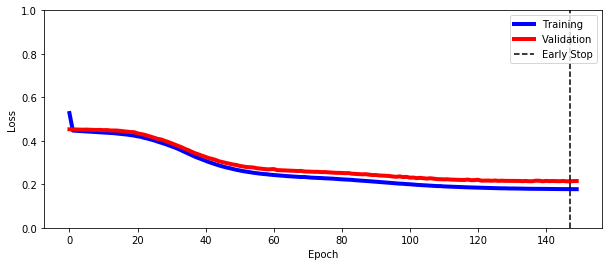

Test Set Performance:
Task 0: Loss: 0.2127	Balanced Accuracy: 83.85%	 auROC: 0.927	 auPRC: 0.853
	Recall at 5%|10%|20% FDR: 58.1%|66.2%|78.2%	 Num Positives: 708	 Num Negatives: 3292
Task 1: Loss: 0.1393	Balanced Accuracy: 89.86%	 auROC: 0.962	 auPRC: 0.913
	Recall at 5%|10%|20% FDR: 72.1%|81.5%|88.0%	 Num Positives: 648	 Num Negatives: 3352
Task 2: Loss: 0.2960	Balanced Accuracy: 72.13%	 auROC: 0.872	 auPRC: 0.599
	Recall at 5%|10%|20% FDR: 0.0%|1.9%|2.7%	 Num Positives: 627	 Num Negatives: 3373


In [18]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
multi_motif_default_model,multi_motif_default_history=train_default_model(multi_motif_data,3)

### Heterodimer Motif Grammar <a name='3e'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 20K 500 bp random sequences with one instance of an SPI1 motif and one instance of an IRF motif. In the positive set of 10K sequences, the pair of motifs are embedded with a relative spacing of 2-5 bp between each other, at any random position in each sequence. In the negative set, the pair of motifs are both randomly embedded with no positional or spacing constraints. 

In [19]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: list
        List of embedding objects.
    


In [20]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

To solve this simulation, the model needs to detect both motifs and learn the spacing constraint between them in the positive set. For this simulation, an architecture with a single convolutional layer does not perform well. Hence, we use a reference architecture with 3 convolutional layers. Each convolutional layer has 15 filters (size 15, stride 1) and ReLU-non-linearity, followed by max-pooling (size 35, stride 35), followed by a fully connected layer with sigmoid non-linearity for binary classification.

Training Data:
Loss: 0.6917	Balanced Accuracy: 50.52%	 auROC: 0.574	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6394	 Num Negatives: 6406
Validation Data:
Loss: 0.6958	Balanced Accuracy: 50.18%	 auROC: 0.479	 auPRC: 0.488
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1589	 Num Negatives: 1611
Training Data:
Loss: 0.6877	Balanced Accuracy: 51.72%	 auROC: 0.637	 auPRC: 0.629
	Recall at 5%|10%|20% FDR: 0.4%|0.6%|3.4%	 Num Positives: 6394	 Num Negatives: 6406
Validation Data:
Loss: 0.6957	Balanced Accuracy: 50.04%	 auROC: 0.491	 auPRC: 0.493
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1589	 Num Negatives: 1611
Training Data:
Loss: 0.6795	Balanced Accuracy: 61.86%	 auROC: 0.669	 auPRC: 0.664
	Recall at 5%|10%|20% FDR: 1.0%|2.5%|9.6%	 Num Positives: 6394	 Num Negatives: 6406
Validation Data:
Loss: 0.6944	Balanced Accuracy: 49.45%	 auROC: 0.498	 auPRC: 0.494
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1589	 Num Negatives: 161

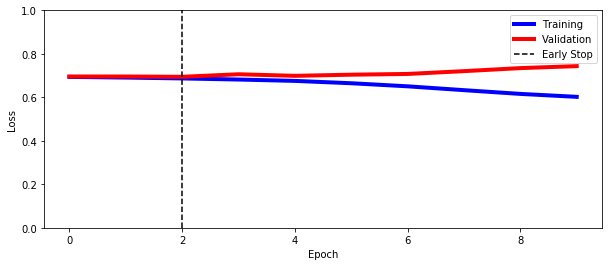

Test Set Performance:
Loss: 0.7393	Balanced Accuracy: 50.49%	 auROC: 0.509	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2017	 Num Negatives: 1983


In [21]:
def build_heterodimer_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))    
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model


#Train default model 
heterodimer_default_model,heterodimer_default_history=train_default_model(heterodimer_data,1,build_heterodimer_model)

Let's store the datasets we have generated in a dictionary to facilitate hyperparameter grid search: 

In [22]:
datasets=dict() 
datasets['SingleMotif_TAL1']=tal1_data 
datasets['DensityDetection']=density_detection_data
datasets['DensityLocalization']=density_localization_data 
datasets['MultipleMotifDetection']=multi_motif_data
datasets['HeterodimerGrammar']=heterodimer_data  

dataset_names=["SingleMotif_TAL1","DensityDetection","DensityLocalization","MultipleMotifDetection","HeterodimerGrammar"]


## Hyperparameter Grid Search<a name='4'>
<a href=#outline>Home</a>

We now systematically vary the number of training examples, size of convolutional filters, number of convolutional filters and size of max pooling to understand the impact of these hyperparameters on prediction performance for each of the simulations.

DragoNN provides several helper functions to perform the hyperparameter grid search 

In [31]:
from dragonn.hyperparameter_search_tutorial import * 

Note: for purposes of this tutorial, we set the training defaults at  150 epochs with a patience threshold of 7. These values can be passed as arguments to the function "hyperparam_train_model" if you would like to use lower values (for faster training) or higher values (to increase confidence that the loss is not stuck at a local minimum). 

In [24]:
help(hyperparam_get_model)

Help on function hyperparam_get_model in module dragonn.hyperparameter_search_tutorial:

hyperparam_get_model(input_shape, num_tasks=1, num_layers=1, num_filters=10, kernel_size=15, pool_size=35)
    Performs hyperparameter search in accordance with Figure 6 in the DragoNN manuscript 
    
    input_shape: tuple with dimensions of input 
    num_tasks: number of prediction tasks, default=1 
    num_layers: number of 2D convolution layers, default=1 
    num_filters: number of filters to use in each 2D convolution layer, default=10 
    kernel_size: filter dimension for each 2D convolution layer, (1,n), default n=15  
    pool_size: 2D MaxPooling pool size, default=35 
    
    Returns a Sequential model with the specified parameters.



In [25]:
help(hyperparam_train_model)

Help on function hyperparam_train_model in module dragonn.hyperparameter_search_tutorial:

hyperparam_train_model(data, model, num_training_examples=None, epochs=150, patience=7)



### Training examples<a name='4a'>
<a href=#outline>Home</a>

In [26]:
#Define grid of possible parameter values 
training_examples_grid=range(500,13000,1000)

training_examples_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    training_examples_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_training_examples in training_examples_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                               num_layers=3,
                                               num_filters=15)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::])
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model,num_training_examples=num_training_examples)
        print("Number of training examples:"+str(num_training_examples)+": auPRC:"+str(cur_auPRC))
        training_examples_test_auPRC[name].append(cur_auPRC)
    
    

SingleMotif_TAL1
Number of training examples:500: auPRC:[0.503895972335995]
Number of training examples:1500: auPRC:[0.49287114101513885]
Number of training examples:2500: auPRC:[0.510263695996098]
Number of training examples:3500: auPRC:[0.5074546489160138]
Number of training examples:4500: auPRC:[0.4982080928470038]
Number of training examples:5500: auPRC:[0.9108182267272807]
Number of training examples:6500: auPRC:[0.5050091608876994]
Number of training examples:7500: auPRC:[0.9252886773929302]
Number of training examples:8500: auPRC:[0.928938024875093]
Number of training examples:9500: auPRC:[0.9324300427091214]
Number of training examples:10500: auPRC:[0.9295229459914082]
Number of training examples:11500: auPRC:[0.9301191228059206]
Number of training examples:12500: auPRC:[0.9323866457394057]
DensityDetection
Number of training examples:500: auPRC:[0.8136198628355586]
Number of training examples:1500: auPRC:[0.9427436989584626]
Number of training examples:2500: auPRC:[0.965131452

Plot the results of the parameter grid search:

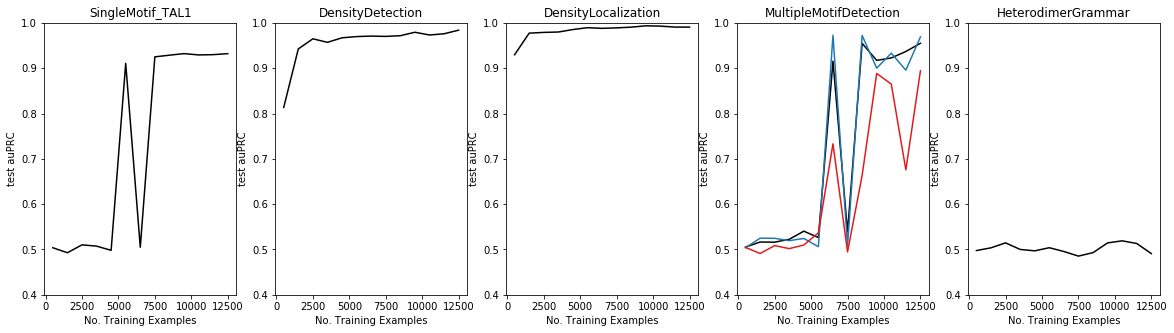

In [45]:
hyperparam_plot_test_auPRC(training_examples_grid,
                           training_examples_test_auPRC,
                           "No. Training Examples",
                           "test auPRC")


### Convolutional Filter Width<a name='4b'>
<a href=#outline>Home</a>


In [ ]:
#Define grid of possible parameter values 
filter_width_grid=range(1,31,10)

filter_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    filter_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for filter_width in filter_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            kernel_size=filter_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          kernel_size=filter_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          kernel_size=filter_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Filter width:"+str(filter_width)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)
    
   

SingleMotif_TAL1
Filter width:1: auPRC:[0.4992391148018685]
Filter width:11: auPRC:[0.960719364178115]
Filter width:21: auPRC:[0.9086059817782752]
DensityDetection
Filter width:1: auPRC:[0.49866481740083785]
Filter width:11: auPRC:[0.9934513782465519]
Filter width:21: auPRC:[0.98079027604944]
DensityLocalization
Filter width:1: auPRC:[0.4970461463362912]
Filter width:11: auPRC:[0.9931490200667994]
Filter width:21: auPRC:[0.9936801735701619]
MultipleMotifDetection


Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(filter_width_grid,
                           filter_width_test_auPRC,
                           "Filter Width",
                           "test auPRC")

### Number of convolution filters<a name='4c'>
<a href=#outline>Home</a>


In [ ]:
#Define grid of possible parameter values 
num_filters_grid=range(1,40,10)

num_filters_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    num_filters_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_filters in filter_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=num_filters)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_tasks=3,
                                            num_filters=num_filters)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          num_filters=num_filters)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Number of Conv. Filters:"+str(num_filters)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(num_filters_grid,
                           num_filters_test_auPRC,
                           "Number of Convolution Filters",
                           "test auPRC")

### Max Pooling Width <a name='4d'>
<a href=#outline>Home</a>

In [ ]:
#Define grid of possible parameter values 
pool_width_grid=range(5,55,10)

pool_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    pool_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for pool_width in pool_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            pool_size=pool_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          pool_size=pool_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          pool_size=pool_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Max Pool Size:"+str(pool_width)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(pool_width_grid,
                           pool_width_test_auPRC,
                           "Max Pool Width",
                           "test auPRC")

## Conclusions<a name='5'>
<a href=#outline>Home</a>

* To fully convince ourselves that the hyperparameters we have found for each dataset are truly optimal, we should repeat this experiment several times and use the average test auPRC for each hyperparameter setting. What happens if your run each parameter tuning step 5 times? 10 times? Do the optimal parameter values we have found  hold?


* We performed parameter grid search "manually" to illustrate how this process works. However, a number of Python packages are available to automate this task. A few notable ones are: 

     * Hyperas (https://github.com/maxpumperla/hyperas)
     * Hyperopt (https://github.com/hyperopt/hyperopt)  
     * MOE (https://github.com/Yelp/MOE) 